# Computer Lab 4: Forecasting Daily Data using Facebook Prophet

**In this practical you will learn:**

* How to wrangle time series data into `Prophet` format
* How to fit a `Prophet` model to a time series
* How to obtain a point forecast and prediction intervals using `Prophet`
* How to model special calender events.
* How to use `Prophet`'s built in diagnostic and cross validation tools

---
* Video to introduce the notebook: https://bit.ly/intro_prophet
> Note that in this video I use a slightly older version of Prophet.  The only material difference is that prior to version 1.0 (that we are using) you imported from `fbprophet` instead of `prophet`!
---

## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

## FB Prophet Imports

If you are using the provided conda environment `hds_forecast` you will already have `prophet` installed.  

> At the time of writing a slightly older version of Prophet is also installed by default in Google Colab.  For this version you will need to use `import fbprophet` instead of `import prophet`

In [2]:
from prophet import Prophet

import prophet

# should be version 1.0
prophet.__version__

'1.1.5'

## forecast-tools imports

In [3]:
# if running in Google Colab install forecast-tools
if 'google.colab' in sys.modules:
    !pip install forecast-tools

In [4]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

# ARIMA imports

At the end of the notebook we will compare Prophet's performance to ARIMA

In [5]:
# if running in Google Colab install pmdarima
if 'google.colab' in sys.modules:
    !pip install pmdarima

from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

# Data - ED reattendances

We will use an time series of patients that reattend an ED within 7 days.  The data are held at the **daily** level.

The data is held in the file `ed_reattends_day.csv`

# Exercise 1: Read in and adjust

**Task:**

* Load `ed_reattends_day.csv` (url provided below)
* Plot the data
* Name the `pd.DataFrame` you create `y_train`

**Hints**

* The data is stored in UK day first format.
* Remember to set the freq of the DataTimeIndex

**Questions**:
* How would you describe the time series?

In [6]:
# your code here ...
url = 'https://raw.githubusercontent.com/health-data-science-OR/' \
      + 'hpdm097-datasets/master/ed_reattends_day.csv'

In [7]:
# example solution
y_train = pd.read_csv(url, parse_dates=True, 
                            dayfirst=True, index_col='date')
y_train.index.freq = 'D'

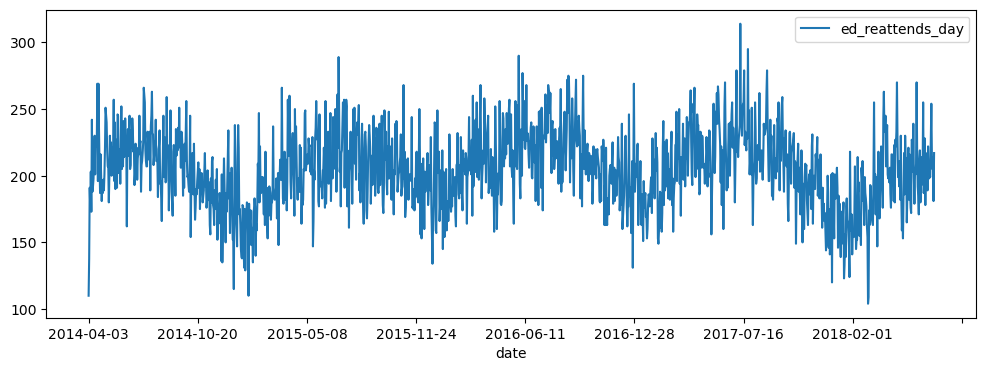

In [8]:
_ = y_train.plot(figsize=(12,4))

# Exercise 2: Wrangle the data into Prophet Format

A `Prophet` model requires the data in a `pd.DataFrame` with two columns: 'ds' - the datetimestamp and `y` the observations used in training (the index is an arbitrary numeric value).  But your current (and standard form) dataframe has a datetimeindex 

**Task:**

* Code a function that converts the training data into the correct format for Prophet.
* The end product should be a dataframe with 2 columns (in the following order)
 * 'ds': the date
 * 'y': the number of reattends on that day.
* Convert your data

In [9]:
# your code goes here...

In [10]:
# example solution

def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

In [11]:
yp_train = prophet_training_data(y_train)

In [12]:
yp_train.head()

,ds,y
0,2014-04-03,110.0
1,2014-04-04,138.0
2,2014-04-05,191.0
3,2014-04-06,176.0
4,2014-04-07,203.0


# Exercise 3: Fit and predict using a basic Prophet model

Fitting a basic Prophet model is relatively straightforward.  We need to create a `Prophet` object

```python
model = Prophet()
```
Unlike ARIMA where we specified the prediction interval width at prediction time, with Prophet we need to specify the interval width as we create the model.  We do this using the parameter `interval_width`.  By default this produces a 80\% prediction interval.  Note we specify a $1-\alpha$ interval width (unlike in ARIMA where we specified $\alpha$)

```python
model = Prophet(interval_width=0.95)
```

and call `.fit()` passing in the training data.

```python
model.fit(y_train)
```

## Exercise 3.1 Fitting
**Task:**

* Fit a basic `Prophet` model to the training data
* Set the model up to produce 95\% prediction intervals

In [13]:
# your code here ...

In [14]:
# example solution
model = Prophet(interval_width=0.95)
model.fit(yp_train)

16:59:12 - cmdstanpy - INFO - Chain [1] start processing
16:59:12 - cmdstanpy - INFO - Chain [1] done processing


# Exercise 3.2 Forecasting

There are two steps to makeing a forecast with a fitted `Prophet` model.  You must first create a future dataframe.  This is a `pd.DataFrame` with a single column 'ds' that runs from the start of the training period until the end of the training period + a horizon.  Prophet makes this easy by including a `make_future_dataframe()` method.

```python
future = model.make_future_dataframe(periods=28)
```

Once we have the future dataframe we can pass that to the predict method.

```python
prophet_forecast = model.predict(future)
```

This returns a `pd.DataFrame` that contains both the in-sample fitted values and the out of sample forecasts. It contains all of the components of the fitted model. For example the last 5 rows of a forecast are:

|      | ds                  |   trend |   yhat_lower |   yhat_upper |   trend_lower |   trend_upper |   additive_terms |   additive_terms_lower |   additive_terms_upper |    weekly |   weekly_lower |   weekly_upper |   yearly |   yearly_lower |   yearly_upper |   multiplicative_terms |   multiplicative_terms_lower |   multiplicative_terms_upper |    yhat |
|-----:|:--------------------|--------:|-------------:|-------------:|--------------:|--------------:|-----------------:|-----------------------:|-----------------------:|----------:|---------------:|---------------:|---------:|---------------:|---------------:|-----------------------:|-----------------------------:|-----------------------------:|--------:|
| 1629 | 2018-09-18 00:00:00 | 187.353 |      163.694 |      236.271 |       186.22  |       188.383 |        11.0807   |              11.0807   |              11.0807   |  -2.83494 |       -2.83494 |       -2.83494 |  13.9156 |        13.9156 |        13.9156 |                      0 |                            0 |                            0 | 198.433 |
| 1630 | 2018-09-19 00:00:00 | 187.305 |      157.7   |      226.979 |       186.153 |       188.356 |         5.91039  |               5.91039  |               5.91039  |  -7.49286 |       -7.49286 |       -7.49286 |  13.4032 |        13.4032 |        13.4032 |                      0 |                            0 |                            0 | 193.215 |
| 1631 | 2018-09-20 00:00:00 | 187.257 |      150.343 |      224.271 |       186.088 |       188.328 |         0.527382 |               0.527382 |               0.527382 | -12.3179  |      -12.3179  |      -12.3179  |  12.8452 |        12.8452 |        12.8452 |                      0 |                            0 |                            0 | 187.785 |
| 1632 | 2018-09-21 00:00:00 | 187.209 |      156.873 |      226.588 |       186.023 |       188.3   |         3.90459  |               3.90459  |               3.90459  |  -8.34281 |       -8.34281 |       -8.34281 |  12.2474 |        12.2474 |        12.2474 |                      0 |                            0 |                            0 | 191.114 |
| 1633 | 2018-09-22 00:00:00 | 187.162 |      169.299 |      241.272 |       185.954 |       188.272 |        15.9777   |              15.9777   |              15.9777   |   4.36149 |        4.36149 |        4.36149 |  11.6162 |        11.6162 |        11.6162 |                      0 |                            0 |                            0 | 203.139 |


We can the plot the forecast using Prophet's built in functionality

```python
model.plot(prophet_forecast);
```

In the plot you will see

* Black dots - these represent the actual observations (training data)
* Blue line - this represents the point forecast
* Light blue shaded region - this is the 95\% prediction interval

**Task:**
* Use your Prophet model to make a 84 day prediction.
* Plot the prediction

In [15]:
# your code here ...

In [16]:
# example solution
future = model.make_future_dataframe(periods=84)
future

,ds
0,2014-04-03
1,2014-04-04
2,2014-04-05
3,2014-04-06
4,2014-04-07
...,...
1629,2018-09-18
1630,2018-09-19
1631,2018-09-20
1632,2018-09-21


In [17]:
prophet_forecast = model.predict(future)
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1629,2018-09-18,187.031835,153.279757,240.381602,186.243253,187.786768,12.045723,12.045723,12.045723,-2.058443,-2.058443,-2.058443,14.104166,14.104166,14.104166,0.0,0.0,0.0,199.077558
1630,2018-09-19,186.983695,150.997801,233.388048,186.180324,187.749937,5.656802,5.656802,5.656802,-7.973121,-7.973121,-7.973121,13.629923,13.629923,13.629923,0.0,0.0,0.0,192.640497
1631,2018-09-20,186.935555,148.058653,229.609417,186.117191,187.713105,1.309130,1.309130,1.309130,-11.806180,-11.806180,-11.806180,13.115310,13.115310,13.115310,0.0,0.0,0.0,188.244685
1632,2018-09-21,186.887415,153.491100,231.613294,186.054450,187.676274,4.159986,4.159986,4.159986,-8.406516,-8.406516,-8.406516,12.566502,12.566502,12.566502,0.0,0.0,0.0,191.047401
1633,2018-09-22,186.839275,161.629657,243.905457,185.993326,187.639442,15.437608,15.437608,15.437608,3.447619,3.447619,3.447619,11.989989,11.989989,11.989989,0.0,0.0,0.0,202.276883


/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


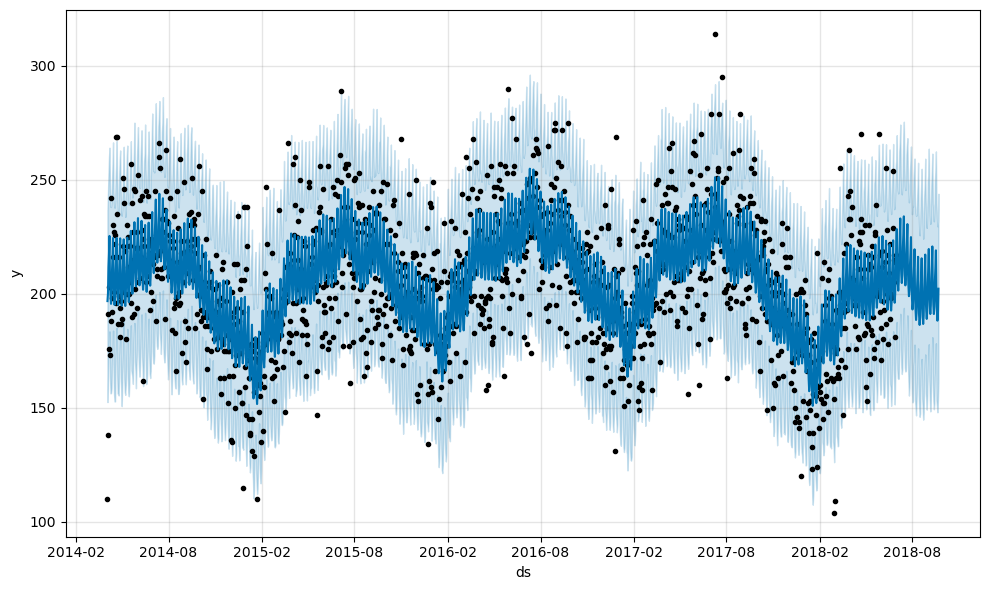

In [18]:
model.plot(prophet_forecast);

# Exercise 4: Plot the model components

To decompose the Prophet model and see the trend and seasonal components you can call:

```python
model.plot_components(forecast)
```

**Task:**

* Plot the Prophet model's trend and seasonal components.


**Questions:**
* What observations can you make about the weekly (i.e. days of the week) and yearly (i.e months of the year) seasonality?

/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

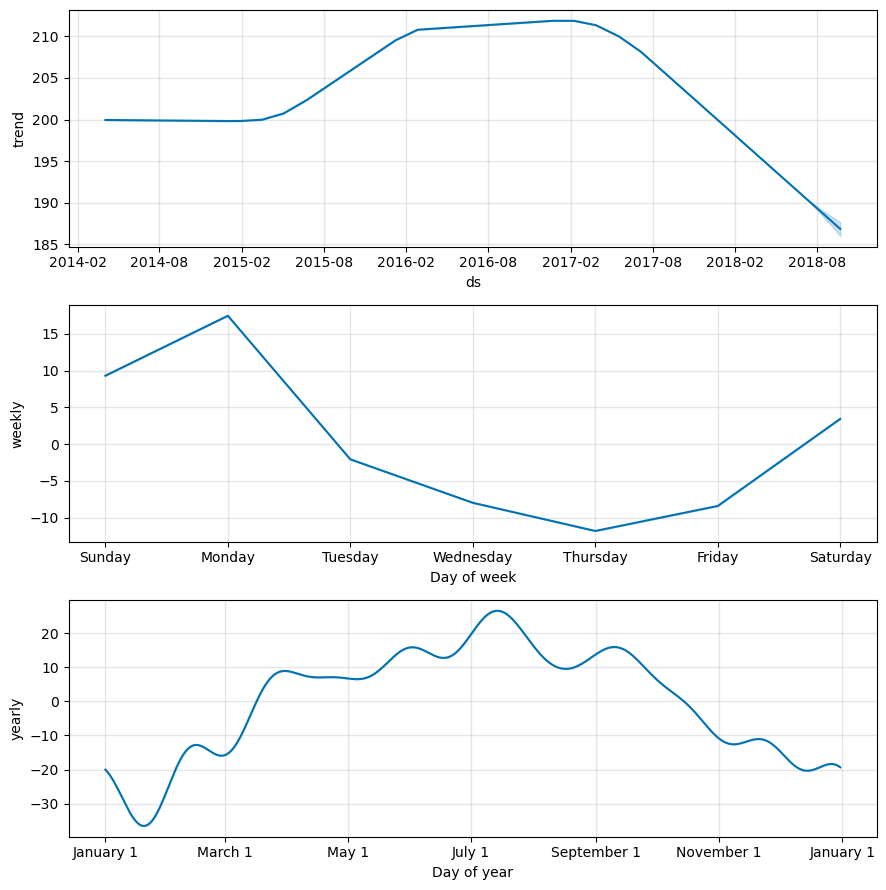

In [19]:
model.plot_components(prophet_forecast);


# Exercise 5: Adding standard holidays

As this is ED reattendance data at the daily level, it is likely that we will be seeing some calender day/holiday effects.  Prophet has been designed to deal with 'holidays'.  Effectively a series of binary variables are added for each holiday.

Prophet has a number of standard holidays built in by country.  To add them in for 'UK' you would use the following code:

```python
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='UK')
model.fit(y_train)
```

Note that you call the `add_country_holidays` **before** you fit the model.  This is because it is command telling Prophet what you would like to fit.

To see what models have been fitted you can call:

```python
model.train_holiday_names.to_list()
```

When you plot the components of the model a new panel will be added for holidays.  It can sometimes be a bit difficult to which holidays are having which effect so you can plot individual holidays as follows:

```python
from prophet.plot import plot_forecast_component

plot_forecast_component(model, prophet_forecast, 'Christmas Day');
```

**Task:**

* Modify your code to include a holidays for 'UK'
* Make an 84 day forecast
* Plot the model components. 
* Explore the holidays

**Questions:**

* What do you notice about Christmas day, and Good Friday?  Are there any other days that appear important?

**Hints:**
* Take a look at the new forecast dataframe.  This includes new columns with the effect of each `holidays`.

In [20]:
# your code here ...

In [21]:
# example solution
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='UK')
model.fit(yp_train)

16:59:14 - cmdstanpy - INFO - Chain [1] start processing
16:59:14 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
model.train_holiday_names.to_list()

['Good Friday',
 'May Day',
 'Spring Bank Holiday',
 "New Year's Day",
 'Christmas Day',
 'Christmas Day (observed)',
 'Boxing Day',
 "New Year's Day (observed)",
 'Boxing Day (observed)']

In [23]:
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)

/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

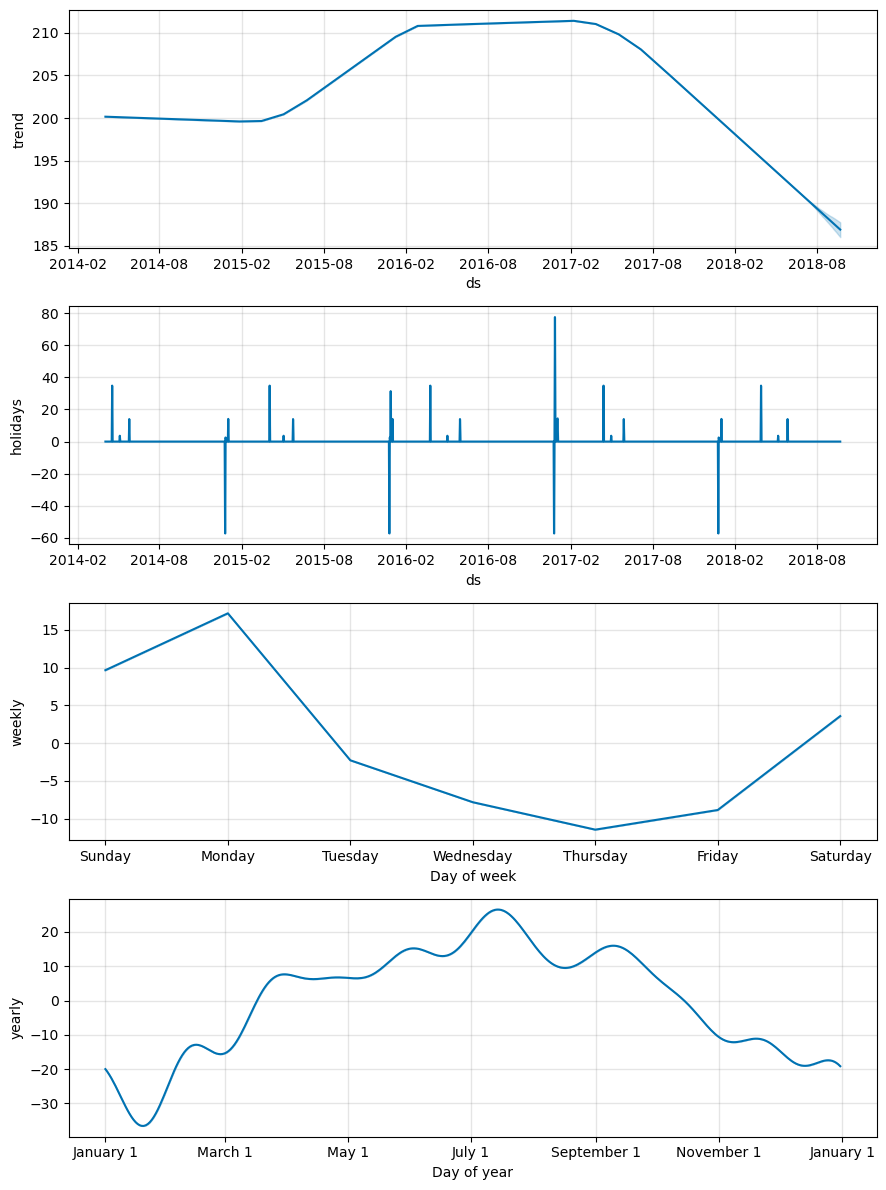

In [24]:
model.plot_components(prophet_forecast);

In [25]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Boxing Day', 'Boxing Day_lower', 'Boxing Day_upper',
       'Boxing Day (observed)', 'Boxing Day (observed)_lower',
       'Boxing Day (observed)_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (observed)',
       'Christmas Day (observed)_lower', 'Christmas Day (observed)_upper',
       'Good Friday', 'Good Friday_lower', 'Good Friday_upper', 'May Day',
       'May Day_lower', 'May Day_upper', 'New Year's Day',
       'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (observed)', 'New Year's Day (observed)_lower',
       'New Year's Day (observed)_upper', 'Spring Bank Holiday',
       'Spring Bank Holiday_lower', 'Spring Bank Holiday_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_

/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


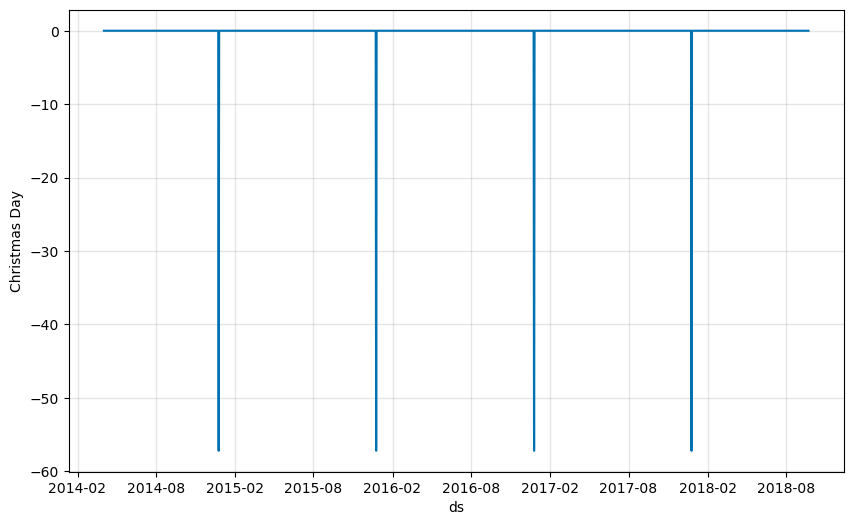

In [26]:
from prophet.plot import plot_forecast_component
plot_forecast_component(model, prophet_forecast, 'Christmas Day');

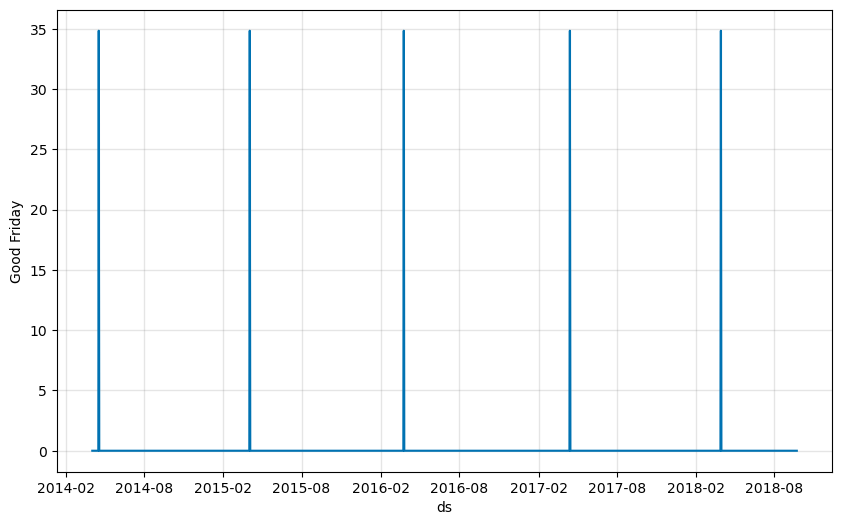

In [27]:
plot_forecast_component(model, prophet_forecast, 
                        'Good Friday');

In [28]:
# Adding a day of month seasonality.

16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:15 - cmdstanpy - INFO - Chain [1] done processing
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of 

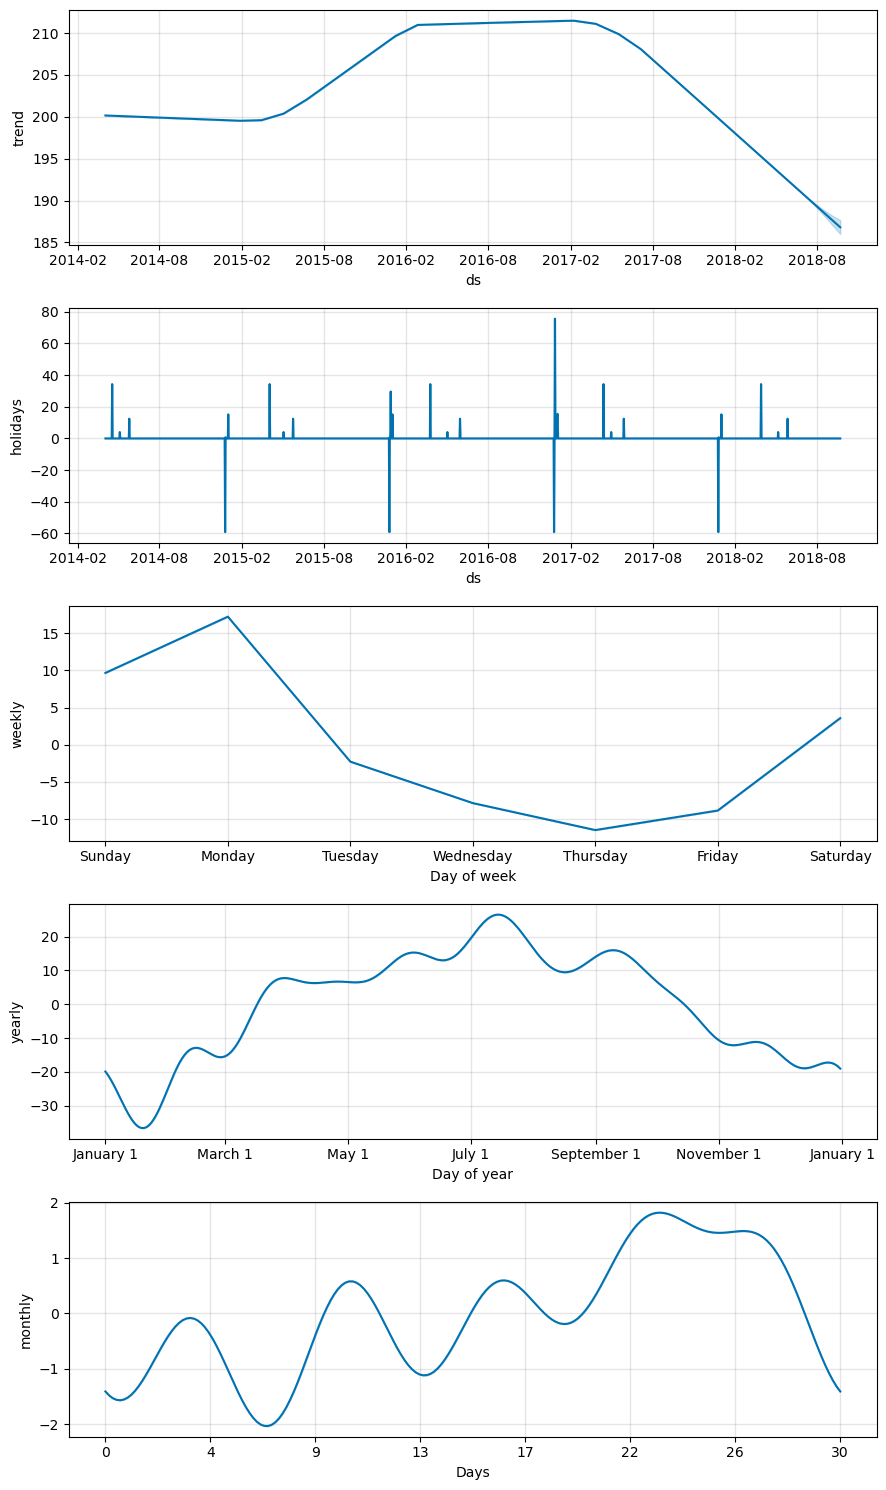

In [29]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='UK')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=84)
prophet_forecast = model.predict(future)
model.plot_components(prophet_forecast);

# Exercise 6: Cross Validation

FBProphet provides its own cross validation procedures in the `diagnostics` module.  Two key functions are the `cross_validation` and `performance_metrics` functions.

```python
from prophet.diagnostics import cross_validation, performance_metrics
```

Prophet uses a rolling origin forecast type procedure for cross validation (but rather than working forwards Prophet works backwards from the final fold).  The `cross_validation` function requires some parameters to be **time delta** compatable.  This means that we need to pass in a `str` such as `"7 days"`

To use the `cross_validation` function with your model to do a CV where the initial length of the training set is 1095 days (3 years), the step size (period) is 28 days and the forecast horizon is 84 days we would use the following code:

```python
df_cv = cross_validation(model=model, initial='1095 days', period='28 days', 
                         horizon='84 days')
```

The variable `df_cv` is of type `pandas.DataFrame`.  It contains all of the predictions and actual values by date and cut off.  In our example above the first row will be day 366; the next 83 rows will be all part of the same cross-validation fold.  See below for example, note that all the select rows (0, 1 and 83) have the same **cut-off** - this the **forecast origin** of the cross validation fold.

```python
df_cv.iloc[[0, 1, 83]
```

|    | ds                  |    yhat |   yhat_lower |   yhat_upper |   y | cutoff              |
|---:|:--------------------|--------:|-------------:|-------------:|----:|:--------------------|
|  0 | 2017-04-09 00:00:00 | 215.292 |      180.674 |      249.161 | 241 | 2017-04-08 00:00:00 |
|  1 | 2017-04-10 00:00:00 | 222.806 |      187.367 |      255.534 | 259 | 2017-04-08 00:00:00 |
| 83 | 2017-07-01 00:00:00 | 234.83  |      200.091 |      270.619 | 221 | 2017-04-08 00:00:00 |


If we then look at rows 84 and 85 we see that the cutoff (forecast origin) has rolled forward.  It is equal to the previous cut-off + 28 days (period in prophet terminology).

```python
df_cv.iloc[[84, 85]
```

|    | ds                  |    yhat |   yhat_lower |   yhat_upper |   y | cutoff              |
|---:|:--------------------|--------:|-------------:|-------------:|----:|:--------------------|
| 84 | 2017-05-07 00:00:00 | 226.971 |      192.175 |      260.083 | 217 | 2017-05-06 00:00:00 |
| 85 | 2017-05-08 00:00:00 | 234.145 |      198.177 |      269.963 | 213 | 2017-05-06 00:00:00 |


So in essence `df_cv` is a record of all of the cross-validation folds stacked on top of each other.  This is useful, because it means have all of the data to calculate any forecast error measure we would like for over any sub-forecast horizon.  Prophet provides the function `performance_metrics` and the plotting function `fbprophet.plot.plot_cross_validation_metric` to automate this for you.  For example:

**Note: mdape is median absolute percentage error**

```python
df_p = performance_metrics(df_cv)
df_p.head()
```
|    | horizon          |     mse |    rmse |     mae |      mape |     mdape |   coverage |
|---:|:-----------------|--------:|--------:|--------:|----------:|----------:|-----------:|
|  0 | 9 days 00:00:00  | 387.234 | 19.6783 | 15.6597 | 0.0798998 | 0.0632103 |   0.91453  |
|  1 | 10 days 00:00:00 | 355.57  | 18.8566 | 14.9167 | 0.0775167 | 0.0632103 |   0.931013 |
|  2 | 11 days 00:00:00 | 317.469 | 17.8176 | 13.8917 | 0.0726941 | 0.0535132 |   0.945665 |
|  3 | 12 days 00:00:00 | 311.386 | 17.6461 | 13.8011 | 0.0719934 | 0.0535132 |   0.954212 |
|  4 | 13 days 00:00:00 | 321.142 | 17.9204 | 13.908  | 0.0719082 | 0.0575246 |   0.948718 |

---
**Task:**
* Run Prophet's built in cross validation
* Use an initial training period of 1095 days, period=28 and horizon of '84 days'
* Use Prophet's built in `cross_validation` and `performance_metrics` functions


In [30]:
# your code here...

In [31]:
# example answer...
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [32]:
df_cv = cross_validation(model, initial='1095 days', period='28 days', horizon='84 days')

  0%|          | 0/14 [00:00<?, ?it/s]

16:59:16 - cmdstanpy - INFO - Chain [1] start processing
16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:18 - cmdstanpy - INFO - Chain [1] start processing
16:59:18 - cmdstanpy - INFO - Chain [1] done processing
16:59:18 - cmdstanpy - INFO - Chain [1] start processing
16:59:18 - cmdstanpy - INFO - Chain [1] done processing
16:59:18 - cmdstanpy - INFO - Chain [1] start processing
16:59:18 - cmdstanpy - INFO - Chain [1] done processing
16:59:18 - cmdstanpy - INFO - Chain [1] start processing
16:59:19 - cmdstanpy - INFO - Chain [1]

In [33]:
#rolling window = 0 means that we get an average for each horizon
#rolling window = 1 means that we only get the 84 day horizon
#rolling window between 0 and 1 varies the percentage of points in each horizon.
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,84 days,553.391842,23.524282,18.98458,0.100561,0.080271,0.095849,0.909864


/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


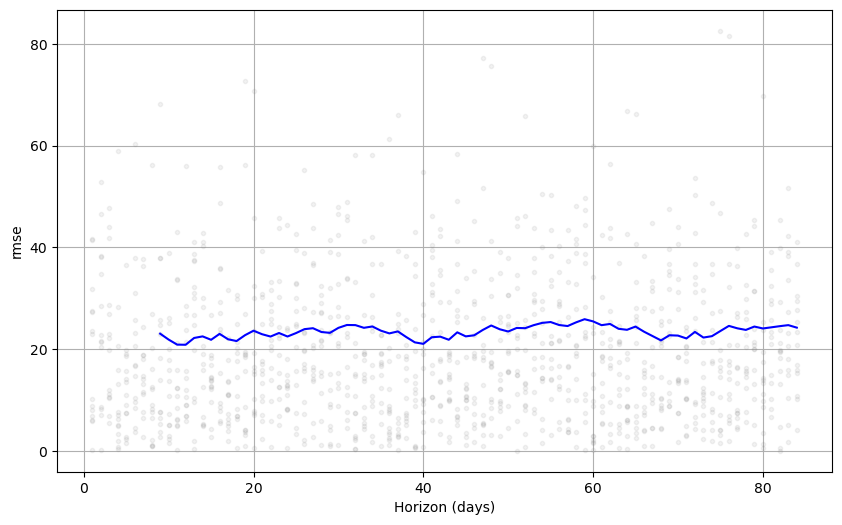

In [34]:
fig = plot_cross_validation_metric(df_cv, metric='rmse', rolling_window=0.1)

# Exercise 7: Is Prophet better than ARIMA?

**Task:**
* Choose and fit an ARIMA model to the dataset.
* Use cross-validation of the 84 day MAE compare the performance of ARIMA and Prophet.

**Questions**
* Which of the two methods would you choose in practice? 
* What else might you do?

**Hints**:
* See Introduction to ARIMA notebook for a reminder about how to use ARIMA models in Python
* This is daily level data.  For ARIMA this is `m=7`
* Remember that Prophet and ARIMA use data in different formats. 
* It might take a few minutes for `auto_arima` to return results.  Once it has write down the order of the model so that you can easily recreate it with a `ARIMA` object.
* ARIMA fitting is not always stable for daily level data and procedures may output some warnings.  Types of warning you may encounter are:

**Convergence warning**: 

Where the the Maximum likelihood optimisation has failed to converge. If you get a convergence warning when fitting `ARIMA` to your chosen specification then try passing increasing the parameter `maxiter` (default=50) to 100 or more in the `auto_arima` function and `ARIMA` constructor method.

**Non-invertible starting MA parameters warning**.  

Details of what is meant by an invertible MA process can be found [here](https://otexts.com/fpp2/MA.html).  For our practical purposes the chances are if you see this then when using `auto_arima` and it is unlikely that this model will be selected by the procedure. There is a good chance the warning will also be encountered in cross validation when the model is using less data.  Its worth knowing that `statsmodels` will still fit a model in these circumstances.

* If you wish you can surpress the warnings in `auto_arima` by setting `supress_warnings=True`
* It will also take a few minutes for ARIMA cross validation to run.

In [35]:
# your code here

In [36]:
arima_model = auto_arima(y_train, m=7, maxiter=100, suppress_warnings=True)
arima_model

ARIMA(maxiter=100, order=(2, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 2, 7), suppress_warnings=True,
      with_intercept=False)

In [37]:
# Alternative model to try = SARIMAX(1, 1, 2)x(1, 0, [1], 7)
# model returned = SARIMAX(2, 1, 1)x(0, 0, 2, 7)
arima_model = ARIMA(order=(1, 1, 2), seasonal_order=(0, 0, 2, 7), maxiter=100)
arima_model.fit(y_train)
arima_model.summary()

/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1550
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -7045.744
Date:                           Tue, 30 Jul 2024   AIC                          14105.489
Time:                                   17:00:52   BIC                          14142.906
Sample:                               04-03-2014   HQIC                         14119.406
                                    - 06-30-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0056      0.033      0.171      0.865      -0.059       0.070
ar.L1          0.4042      0.107      3.775      0.000       0.194       0.614
ma.L1         -1.1198      0.113     -9.869      0.000      -1.342      -0.897
ma.L2          0.1639      0.103      1.585      0.113      -0.039       0.367
ma.S.L7        0.1674      0.026      6.333      0.000       0.116       0.219
ma.S.L14       0.0937      0.025      3.685      0.000       0.044       0.144
sigma2       522.2435     17.379     30.049      0.000     488.180     556.307
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.58
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.13
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA cross validation



In [ ]:
# cv of 84 day forecast
cv = RollingForecastCV(h=84, step=28, initial=1095)
scores1 = cross_val_score(arima_model, y_train, cv=cv, verbose=0, 
                              scoring='mean_absolute_error')

/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/tom/miniforge3/envs/hds_forecast/lib/python3.11/site-packages/statsmodels/

In [ ]:
# Prophet 84 day was ~19
scores1.mean()

In [ ]:
# naive model?

In [ ]:
# selects ensemble naive and produces similar performance to ARIMA 
# (although we haven't checked prediction interval coverage)
naive_results = auto_naive(y_train, horizon=84, min_train_size=1095,
                           seasonal_period=7, step=28, method='ro')
naive_results